In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wsi.utils import processed_data_path, raw_data_path
from wsi.mapping.iso_name import ISO_NAME

index_baseline = pd.read_csv(processed_data_path("womens_safety_index_baseline.csv"))
path = raw_data_path("violence", "WorldBank_GenderStatistics_IntimatePartner.csv")
df = pd.read_csv(path)
df = df.iloc[:530, :] # delete trailing na rows

# DHS IPV data
SG.VAW.IPVE.ZS
Proportion of women who have ever experienced intimate partner violence (% of ever-married women ages 15-49)

In [34]:
df['Series Code'].unique()

array(['SG.VAW.1549.LT.ME.ZS', 'SG.VAW.IPVE.ZS'], dtype=object)

In [35]:
df_filtered = df[df['Series Code'] == 'SG.VAW.IPVE.ZS']

# for modelled estimate
df_filtered = df[df['Series Code'] == 'SG.VAW.1549.LT.ME.ZS']
df_pivot = df_filtered.set_index('Country Code').drop(columns=['Series Name', 'Series Code', 'Country Name'])
df_pivot.columns = df_pivot.columns.str.extract(r'(\d{4})')[0].astype(int)
df_pivot = df_pivot.reset_index()  # Make Country Code a column
df_long = df_pivot.melt(id_vars='Country Code', var_name='Year', value_name='IPV').rename(columns={'Country Code':'ISO_code'})

# for modelled estimate
df_long = df_long[df_long['Year']==2018]
df_long.head()

,ISO_code,Year,IPV
15370,AFG,2018,46.0
15371,ALB,2018,13.0
15372,DZA,2018,NaN
15373,ASM,2018,NaN
15374,AND,2018,NaN


In [36]:
merged = pd.merge(df_long, index_baseline,
                  on=['ISO_code', 'Year'],
                  how='inner')
merged = merged.dropna(subset=['IPV'])

merged['IPV']  = pd.to_numeric(merged['IPV'],  errors='coerce')
merged['Year'] = pd.to_numeric(merged['Year'], errors='coerce')
merged = merged.dropna(subset=['IPV', "WSI (Baseline)"])
merged.head()

,ISO_code,Year,IPV,Education,Employment,Parliamentary Representation,Poverty,Legal Protection Index,Son Bias,Maternal Mortality,...,Child Marriage (score),Access Water Sanitation (score),Access Electricity (score),Cell Phone Use (score),Financial Inclusion (score),Equity,Protection,Resilience,WSI (Baseline),Economy
0,AFG,2018,46.0,0.448699,18.845366,27.444795,41.617632,0.229167,105.3,663.42750,...,0.575555,0.525649,0.933468,0.187532,0.054020,0.263364,0.700646,0.425167,0.428093,Afghanistan
1,ALB,2018,13.0,0.938384,61.251300,27.857143,0.000000,0.937500,108.4,5.42929,...,0.845953,0.972558,1.000000,0.295419,0.390069,0.676802,0.813649,0.664511,0.715265,Albania
3,AGO,2018,38.0,0.603410,67.993270,30.454545,31.100000,0.812500,102.6,233.09626,...,0.604439,0.488122,0.448589,0.133023,0.217101,0.546076,0.715639,0.321709,0.500960,Angola
5,ARG,2018,27.0,1.038603,61.964635,39.513678,1.000000,0.687500,105.3,33.94483,...,0.797650,0.958828,1.000000,0.413044,0.539713,0.661592,0.847694,0.727896,0.741822,Argentina
6,ARM,2018,10.0,0.998816,59.338195,18.095238,1.300000,0.812500,110.8,25.10140,...,0.930809,0.953746,0.998992,0.395031,0.413325,0.634587,0.821737,0.690274,0.711348,Armenia


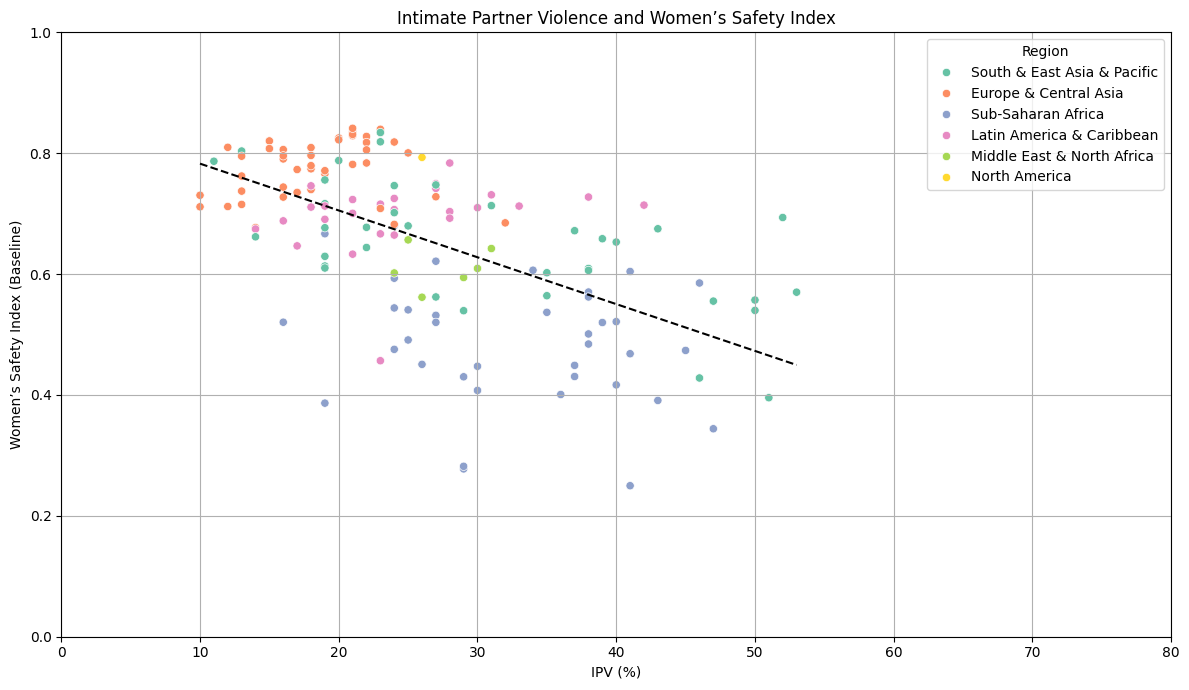

In [37]:
import seaborn as sns

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=merged,
    x='IPV',
    y='WSI (Baseline)',
    hue='Region',
    palette='Set2',  # or use another palette like 'Set2', 'Dark2', etc.
    alpha=1
)

# Linear fit
m, b = np.polyfit(merged['IPV'], merged['WSI (Baseline)'], 1)
x = np.array([merged['IPV'].min(), merged['IPV'].max()])
plt.plot(x, m * x + b, linestyle='--', color='black', label=f'Fit: y={m:.2f}x+{b:.1f}')

plt.xlabel('IPV (%)')
plt.ylabel("Women’s Safety Index (Baseline)")
plt.title('Intimate Partner Violence and Women’s Safety Index')
#plt.legend()
plt.grid(True)

plt.xlim(0, 80)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [25]:
ipv_avg = (
    df_long
    .assign(IPV=lambda df: pd.to_numeric(df['IPV'], errors='coerce'))
    .dropna(subset=['IPV'])
    .groupby('ISO_code', as_index=False)['IPV']
    .mean()
    .rename(columns={'IPV': 'Avg_IPV'})
)

wsi_avg = (
    index_baseline
    .assign(WSI=lambda df: pd.to_numeric(df["WSI (Baseline)"], errors='coerce'))
    .dropna(subset=['WSI'])
    .groupby('ISO_code', as_index=False)['WSI']
    .mean()
    .rename(columns={'WSI': 'Avg_WSI'})
)

summary = pd.merge(ipv_avg, wsi_avg, on='ISO_code', how='inner')
summary["Economy"] = summary["ISO_code"].map(ISO_NAME)
summary.head()

,ISO_code,Avg_IPV,Avg_WSI,Economy
0,AFG,46.0,0.319419,Afghanistan
1,AGO,38.0,0.466165,Angola
2,ALB,13.0,0.661070,Albania
3,ARG,27.0,0.706797,Argentina
4,ARM,10.0,0.643111,Armenia


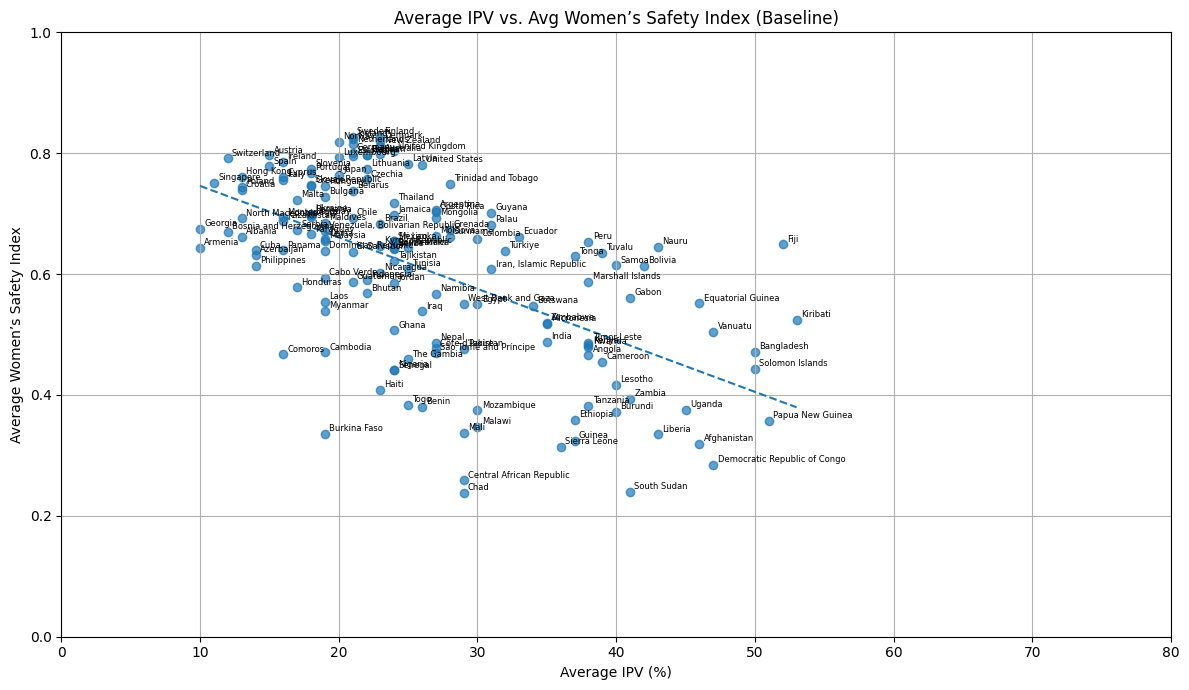

In [26]:
plt.figure(figsize=(12, 7))
plt.scatter(summary['Avg_IPV'], summary['Avg_WSI'], alpha=0.7)

for _, row in summary.iterrows():
    plt.annotate(
        row['Economy'],
        (row['Avg_IPV'], row['Avg_WSI']),
        textcoords="offset points",
        xytext=(3, 2),
        ha='left',
        fontsize=6
    )

# plot the fit line
x_vals = np.array([summary['Avg_IPV'].min(), summary['Avg_IPV'].max()])
m, b = np.polyfit(summary['Avg_IPV'], summary['Avg_WSI'], 1)
plt.plot(x_vals, m * x_vals + b, linestyle='--',
         label=f'Fit: y = {m:.2f}x + {b:.1f}')

plt.xlabel('Average IPV (%)')
plt.ylabel('Average Women’s Safety Index')
plt.title('Average IPV vs. Avg Women’s Safety Index (Baseline)')
#plt.legend()
plt.grid(True)
plt.xlim(0, 80)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()